I work with a star catalogue of 240 stars.
In the first part of the exercise I perform PCA on the dataset using temperature, luminosity, radius and absolute magnitude.
In the second part of the exercise I classify the dataset with K-Nearest Neighbors classifier and I predict stellar types.

In [84]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import os
import scipy.optimize as opt
import scipy.stats as st
import sklearn.manifold
import sklearn.model_selection

# Exploration and Preparation of the data

I need to transform the information regarding Star type, Star color and Spectral class into integers.

In [85]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/nshaud/ml_for_astro/main/stars.csv", "stars.csv")

('stars.csv', <http.client.HTTPMessage at 0x15e2c903b50>)

In [86]:
import pandas as pd
df_stars = pd.read_csv("stars.csv")
df_stars

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,Brown Dwarf,Red,M
1,3042,0.000500,0.1542,16.60,Brown Dwarf,Red,M
2,2600,0.000300,0.1020,18.70,Brown Dwarf,Red,M
3,2800,0.000200,0.1600,16.65,Brown Dwarf,Red,M
4,1939,0.000138,0.1030,20.06,Brown Dwarf,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Hypergiant,Blue,O
236,30839,834042.000000,1194.0000,-10.63,Hypergiant,Blue,O
237,8829,537493.000000,1423.0000,-10.73,Hypergiant,White,A
238,9235,404940.000000,1112.0000,-11.23,Hypergiant,White,A


In [87]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# Assign unique integers from 0 to 5 to each star type
df_stars['Star type'] = le.fit_transform(df_stars['Star type'])
labels = le.inverse_transform(df_stars['Star type'])
class_names = le.classes_
print(class_names)

# Assign unique integers from 0 to 4 to each star color
df_stars['Star color'] = le.fit_transform(df_stars['Star color'])

# Assign unique integers from 0 to 6 to each spectral class
df_stars['Spectral Class'] = le.fit_transform(df_stars['Spectral Class'])

print(df_stars.values[0])

['Brown Dwarf' 'Hypergiant' 'Main Sequence' 'Red Dwarf' 'Supergiant'
 'White Dwarf']
[3.068e+03 2.400e-03 1.700e-01 1.612e+01 0.000e+00 1.000e+01 5.000e+00]


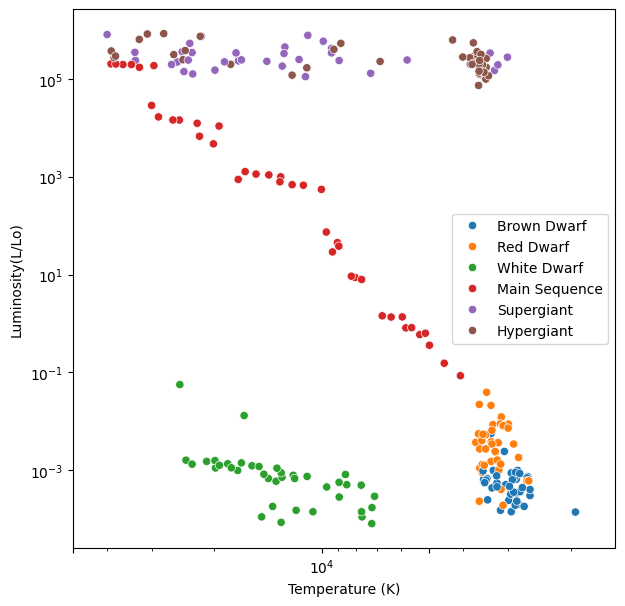

In [88]:
import seaborn as sns

fig = plt.figure(figsize=(7, 7))
sns.scatterplot(data=df_stars, x='Temperature (K)', y='Luminosity(L/Lo)', hue=labels)

plt.xscale('log')
plt.yscale('log')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)
plt.show()

# Part 1: PCA

I  perfrom the PCA using temperature, luminosity, radius and absolute magnitude.

In [89]:
from sklearn.decomposition import PCA

from astroML.datasets import sdss_corrected_spectra
from astroML.utils import pickle_results

#------------------------------------------------------------
# Download data
print('Number of stars: ' + str(len(df_stars)))
print('Number of attributes: ' + str(len(df_stars.values[0])))

Number of stars: 240
Number of attributes: 7


**PCA without scaling**

In [90]:
X = df_stars.to_numpy()

temperature = np.array(X[:, 0], dtype = float)
luminosity = np.array(X[:, 1], dtype = float)
radius = np.array(X[:, 2], dtype = float)
magnitude = np.array(X[:, 3], dtype = float)

data = np.column_stack((temperature, luminosity, radius, magnitude))

n_components = 2
pca = PCA(n_components)
df_stars_reduced = pca.fit_transform(data)

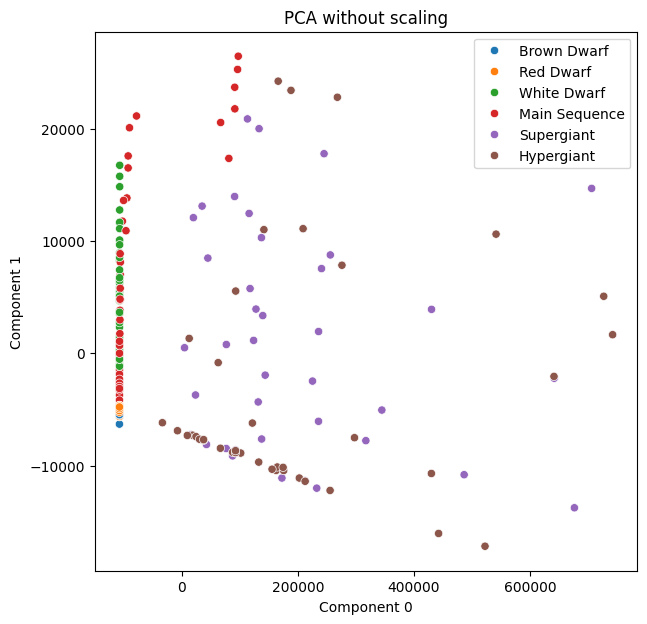

In [91]:
fig = plt.figure(figsize=(7, 7))
sns.scatterplot(x=df_stars_reduced[:,0], y=df_stars_reduced[:,1], hue=labels)
plt.title("PCA without scaling")
plt.xlabel("Component 0")
plt.ylabel("Component 1")
plt.show()

This is not a good result. What happens if I scale the data?

**PCA after scaling**

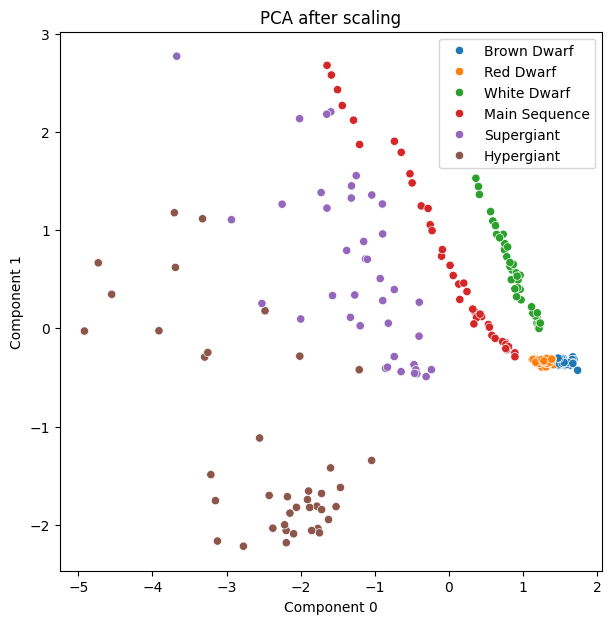

In [92]:
from sklearn.preprocessing import StandardScaler

# scaling
scaler = StandardScaler()
X_transformed = scaler.fit_transform(data)

n_components = 2
pca_new = PCA(n_components)
df_stars_reduced_new = pca_new.fit_transform(X_transformed)

fig = plt.figure(figsize=(7, 7))
sns.scatterplot(x=df_stars_reduced_new[:,0], y=df_stars_reduced_new[:,1], hue=labels)
plt.title("PCA after scaling")
plt.xlabel("Component 0")
plt.ylabel("Component 1")
plt.show()

This is a good result, the star types are now separated.

Now I compute how much variance is explained by the two components:

In [93]:
s = 0
for idx, r in enumerate(pca_new.explained_variance_ratio_):
    s += r
    print(f"Component {idx+1} explains {100*r:.1f}% of the variance (cumulative = {100*s:.1f}%)")

Component 1 explains 60.4% of the variance (cumulative = 60.4%)
Component 2 explains 23.5% of the variance (cumulative = 83.9%)


Now I perform PCA defining 4 components and I plot the scree plots to find the variance explained by each component.

**Scree plots**

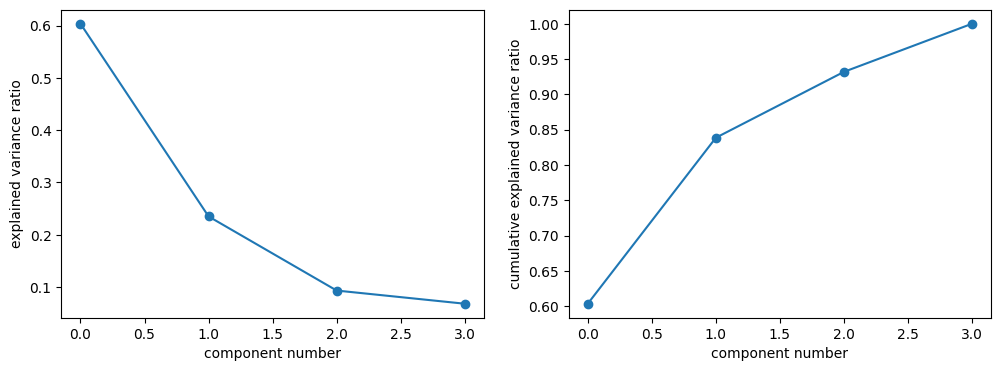

Component 1 explains 60.4% of the variance (cumulative = 60.4%)
Component 2 explains 23.5% of the variance (cumulative = 83.9%)
Component 3 explains 9.3% of the variance (cumulative = 93.2%)
Component 4 explains 6.8% of the variance (cumulative = 100.0%)


In [94]:
n_components = 4
pca = PCA(n_components)
pca.fit(X_transformed)
evals = pca.explained_variance_ratio_ 

# plots
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(np.arange(n_components), evals, marker='o', linestyle='-')
ax[0].set_xlabel("component number")
ax[0].set_ylabel("explained variance ratio")

ax[1].plot(np.arange(n_components), evals.cumsum(), marker='o', linestyle='-')
ax[1].set_xlabel("component number")
ax[1].set_ylabel("cumulative explained variance ratio")

plt.show()

s = 0
for idx, r in enumerate(evals):
    s += r
    print(f"Component {idx+1} explains {100*r:.1f}% of the variance (cumulative = {100*s:.1f}%)")

I can also give a visual representation of how the components reconstruct the data.

Text(0.5, 1.0, 'Reconstruction of the position of a star')

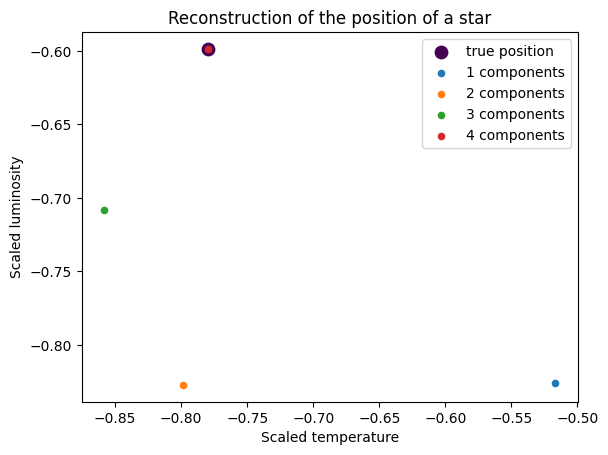

In [95]:
# I take the first star in the dataset and I consider its (scaled) position
true_position = X_transformed[0]
T_true = true_position[0]
L_true = true_position[1]

plt.scatter(T_true, L_true, label='true position', s=80, c=1)

components = [1, 2, 3, 4]
for i in components:
    pca = PCA(i)
    X_projected = pca.fit_transform(X_transformed)
    X_original = pca.inverse_transform(X_projected)
    position = X_original[0]
    plt.scatter(position[0], position[1], label='%i components' %i, s=20)

plt.xlabel('Scaled temperature')
plt.ylabel('Scaled luminosity')
plt.legend()
plt.title('Reconstruction of the position of a star')

# Part 2: K-Nearest Neighbors Classifier

In [96]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

targets = df_stars['Star type']
X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, targets, random_state=42, train_size=0.7)

knc = KNeighborsClassifier(10) # I use 10 nearest neighbors
knc.fit(X_train, Y_train)

y_pred = knc.predict(X_test)

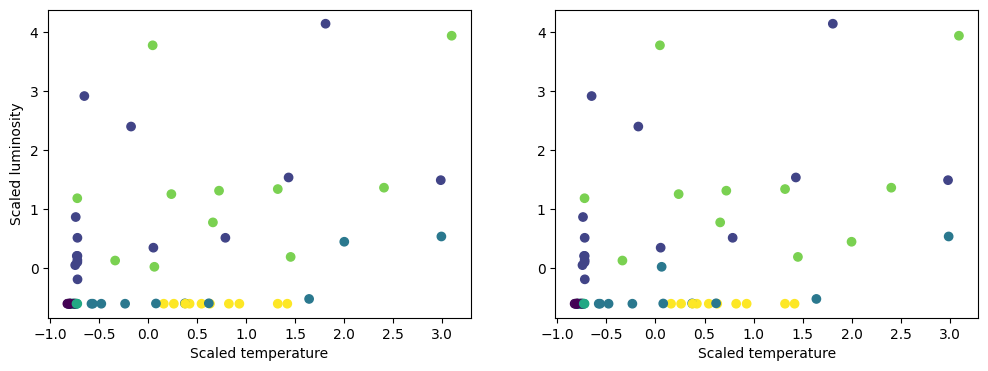

In [97]:
# plots
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].scatter(X_test[:,0], X_test[:,1], c=Y_test)
ax[0].set_xlabel("Scaled temperature")
ax[0].set_ylabel("Scaled luminosity")

ax[1].scatter(X_test[:,0], X_test[:,1], c=y_pred)
ax[1].set_xlabel("Scaled temperature")

plt.show()

In [98]:
# confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, y_pred))

[[14  0  0  0  0  0]
 [ 0 15  0  0  0  0]
 [ 0  0  9  0  1  0]
 [ 0  0  0 12  0  0]
 [ 0  0  1  0 10  0]
 [ 0  0  0  0  0 10]]


There are only 2 misclassified stars.